# ***Haier Europe Sell-In Forecasting Datathon***

## 12-Month Demand Forecasting for SKUs and Product Lines
***The goal of this datathon is to develop a robust forecasting solution capable of generating 12-month demand forecasts for Haier Europe’s product portfolio at both the SKU level and the product line level.***

What Is Expected from Participants
1. 12-Month Forecast Horizon
All models must produce a fixed 12-month forecast with monthly frequency.
2. SKU-Level Forecasts
Forecasts should be generated at the most granular level: per SKU.
SKU-level accuracy is essential for operational and supply planning.
3. Line / Category-Level Consistency
When SKU forecasts are aggregated upward (line → product family → category),
the results should remain consistent, non-contradictory, and business-usable.
4. Handling Phase-Out Products
During the 12-month period, some SKUs will be phased out / discontinued.
Models should:
Let demand for phase-out SKUs converge toward zero.
Preserve seasonality, trends, and promotion effects for ongoing SKUs.
5. Deployable & Business-Ready Solution
The final solution should aim beyond leaderboard performance:
Production-ready
Explainable
Robust to real-world issues (missing data, sudden drops, new SKUs, etc.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm
import warnings
import gc

warnings.filterwarnings('ignore')

# Plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load datasets
# Parsing date columns automatically
train = pd.read_csv('train.csv', parse_dates=['date'])
submission = pd.read_csv('submission.csv', parse_dates=['date'])
product_master = pd.read_csv('product_master.csv', parse_dates=['start_production_date', 'end_production_date'])

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [11]:
def check_df(df, name="DataFrame"):
    print(f"--- {name} Overview ---")
    print(f"Shape: {df.shape}")
    print("\nData Types and Info:")
    print(df.info())
    print("\nFirst 5 Rows:")
    display(df.head())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("-" * 30)

check_df(train, "Train Set")
check_df(product_master, "Product Master")
check_df(submission, "Submission Set")

--- Train Set Overview ---
Shape: (278901, 4)

Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278901 entries, 0 to 278900
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   market        278901 non-null  object        
 1   product_code  278901 non-null  object        
 2   date          278901 non-null  datetime64[ns]
 3   quantity      278901 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 8.5+ MB
None

First 5 Rows:


,market,product_code,date,quantity
0,MKT_001,PRD_0010,2022-01-01,649
1,MKT_001,PRD_0010,2022-02-01,1964
2,MKT_001,PRD_0010,2022-03-01,1505
3,MKT_001,PRD_0010,2022-04-01,1602
4,MKT_001,PRD_0010,2022-05-01,1816



Missing Values:
market          0
product_code    0
date            0
quantity        0
dtype: int64
------------------------------
--- Product Master Overview ---
Shape: (14351, 10)

Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14351 entries, 0 to 14350
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_code           14351 non-null  object        
 1   category               14351 non-null  object        
 2   business_line_code     14351 non-null  object        
 3   business_line          14351 non-null  object        
 4   sector                 14350 non-null  object        
 5   structure_code         14349 non-null  object        
 6   factory                14351 non-null  object        
 7   brand                  14351 non-null  object        
 8   start_production_date  14095 non-null  datetime64[ns]
 9   end_production_date    7972 non

,product_code,category,business_line_code,business_line,sector,structure_code,factory,brand,start_production_date,end_production_date
0,PRD_7747,CAT_01,BLC_01,BL_01,SECTOR_01,STR_01,FACTORY_01,BRAND_01,2022-05-25,2024-03-18
1,PRD_12705,CAT_02,BLC_02,BL_02,SECTOR_02,STR_02,FACTORY_02,BRAND_02,2013-12-17,2016-12-01
2,PRD_13060,CAT_03,BLC_02,BL_02,SECTOR_03,STR_03,FACTORY_03,BRAND_02,NaT,2020-10-05
3,PRD_8689,CAT_04,BLC_02,BL_03,SECTOR_03,STR_03,FACTORY_04,BRAND_02,2016-03-30,2018-01-26
4,PRD_13150,CAT_04,BLC_02,BL_03,SECTOR_03,STR_03,FACTORY_04,BRAND_02,2016-03-30,2018-01-26



Missing Values:
product_code                0
category                    0
business_line_code          0
business_line               0
sector                      1
structure_code              2
factory                     0
brand                       0
start_production_date     256
end_production_date      6379
dtype: int64
------------------------------
--- Submission Set Overview ---
Shape: (249996, 4)

Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249996 entries, 0 to 249995
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ID           249996 non-null  int64         
 1   unique_code  249996 non-null  object        
 2   date         249996 non-null  datetime64[ns]
 3   quantity     249996 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.6+ MB
None

First 5 Rows:


,ID,unique_code,date,quantity
0,0,MKT_001-PRD_0010,2024-11-01,0
1,1,MKT_001-PRD_0010,2024-12-01,0
2,2,MKT_001-PRD_0010,2025-01-01,0
3,3,MKT_001-PRD_0010,2025-02-01,0
4,4,MKT_001-PRD_0010,2025-03-01,0



Missing Values:
ID             0
unique_code    0
date           0
quantity       0
dtype: int64
------------------------------


Statistics for Quantity:
count    278901.000000
mean        120.665344
std         434.584666
min       -8315.000000
25%           3.000000
50%          19.000000
75%          87.000000
max       49254.000000
Name: quantity, dtype: float64

Number of Negative Sales (Returns): 22025
Number of Zero Sales: 410


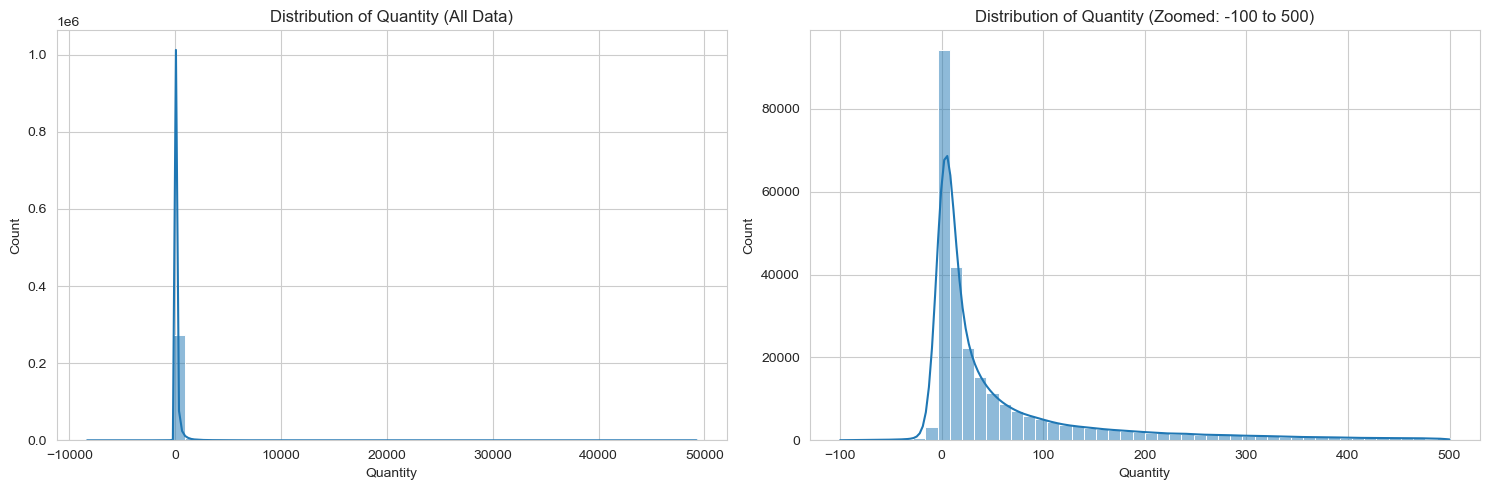

In [13]:
# Basic Statistics
print("Statistics for Quantity:")
print(train['quantity'].describe())

# Check for negative sales (Returns) and zero sales
negative_sales = train[train['quantity'] < 0]
zero_sales = train[train['quantity'] == 0]

print(f"\nNumber of Negative Sales (Returns): {len(negative_sales)}")
print(f"Number of Zero Sales: {len(zero_sales)}")

# Distribution Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(train['quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity (All Data)')
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
# Zooming in to see the core distribution (e.g., between -100 and 500)
sns.histplot(train[train['quantity'].between(-100, 500)]['quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity (Zoomed: -100 to 500)')
plt.xlabel('Quantity')

plt.tight_layout()
plt.show()

/var/folders/bx/yr5y_s2x1qx5kr7kd_c87zvc0000gn/T/ipykernel_70737/3295593806.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')


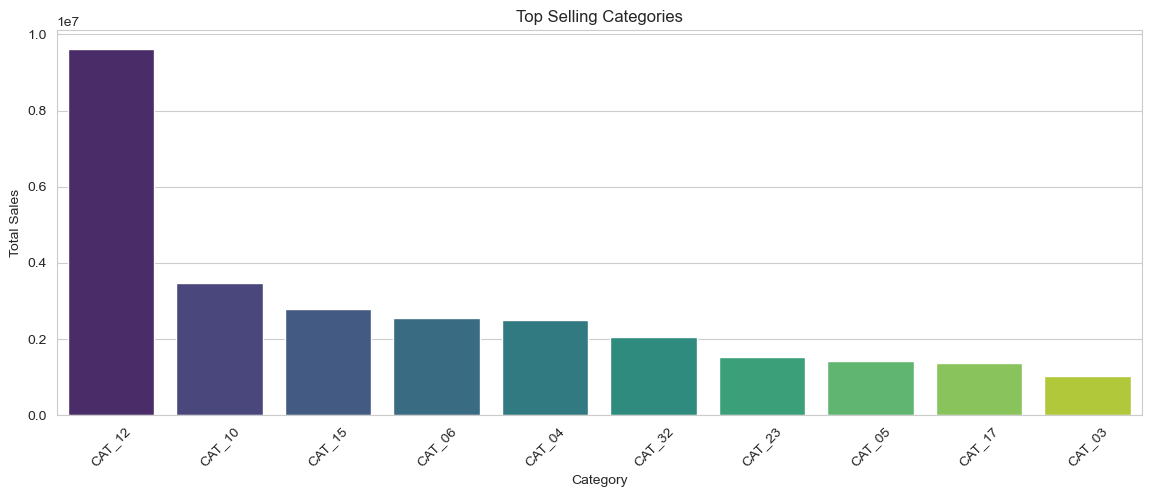

/var/folders/bx/yr5y_s2x1qx5kr7kd_c87zvc0000gn/T/ipykernel_70737/3295593806.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_markets.index, y=top_markets.values, palette='magma')


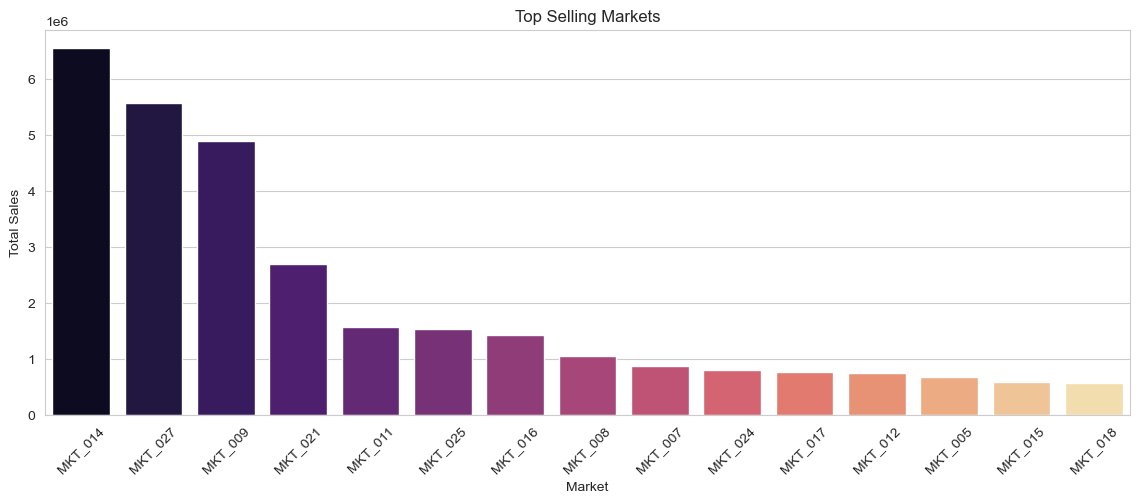

In [17]:
# Merge train with product_master (Left join)
train_merged = train.merge(product_master, on='product_code', how='left')

# Top Selling Categories
top_categories = train_merged.groupby('category')['quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 5))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
plt.title('Top Selling Categories')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

# Top Selling Markets
top_markets = train_merged.groupby('market')['quantity'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(14, 5))
sns.barplot(x=top_markets.index, y=top_markets.values, palette='magma')
plt.title('Top Selling Markets')
plt.xlabel('Market')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

/var/folders/bx/yr5y_s2x1qx5kr7kd_c87zvc0000gn/T/ipykernel_70737/3606063895.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bl_sales.values, y=bl_sales.index, palette='cool')


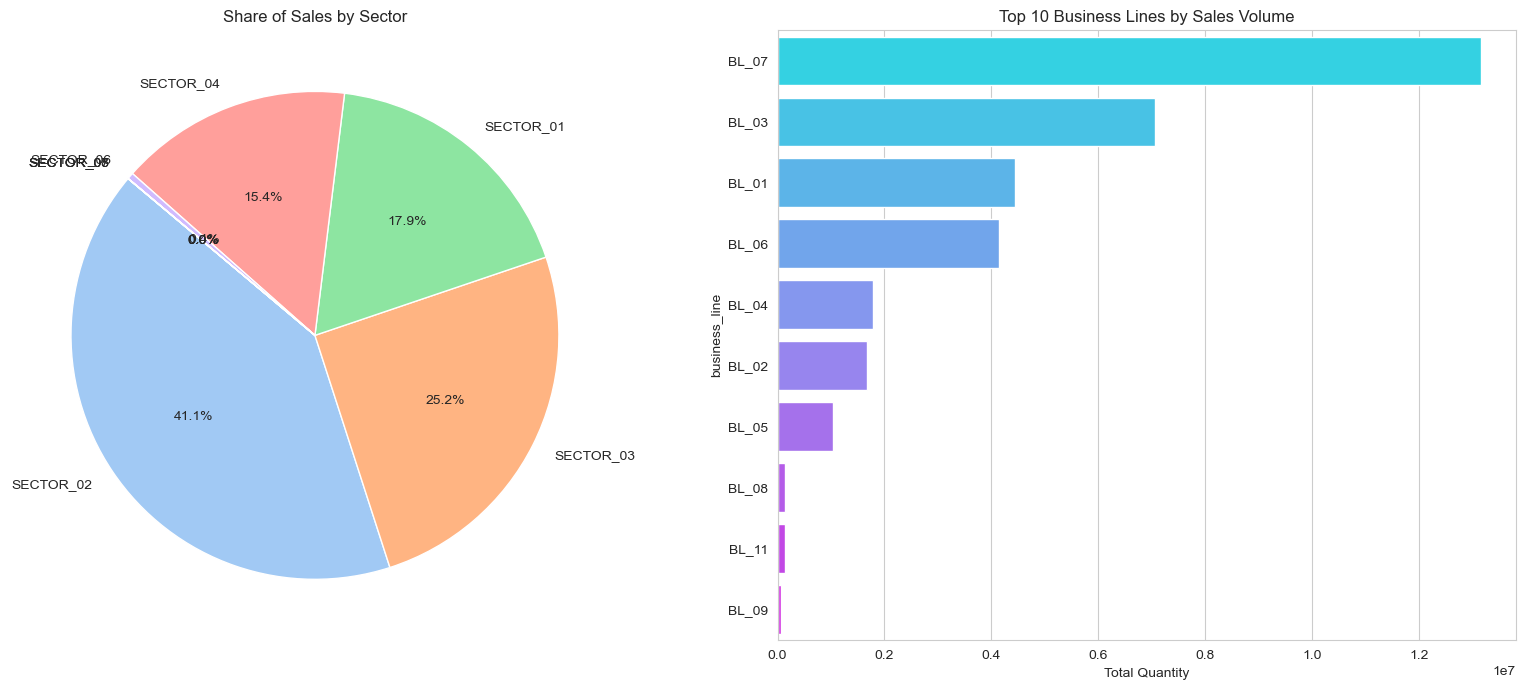

In [29]:
# Merge if not already done
if 'sector' not in train.columns:
    train = train.merge(product_master[['product_code', 'sector', 'business_line']], on='product_code', how='left')

plt.figure(figsize=(16, 7))

# Plot 1: Sales by Sector
plt.subplot(1, 2, 1)
sector_sales = train.groupby('sector')['quantity'].sum().sort_values(ascending=False)
plt.pie(sector_sales, labels=sector_sales.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Share of Sales by Sector')

# Plot 2: Sales by Business Line (Top 10)
plt.subplot(1, 2, 2)
bl_sales = train.groupby('business_line')['quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=bl_sales.values, y=bl_sales.index, palette='cool')
plt.title('Top 10 Business Lines by Sales Volume')
plt.xlabel('Total Quantity')

plt.tight_layout()
plt.show()

Since product_master contains hierarchical info (sector, business_line), visualizing shares at this level gives a high-level strategic view.

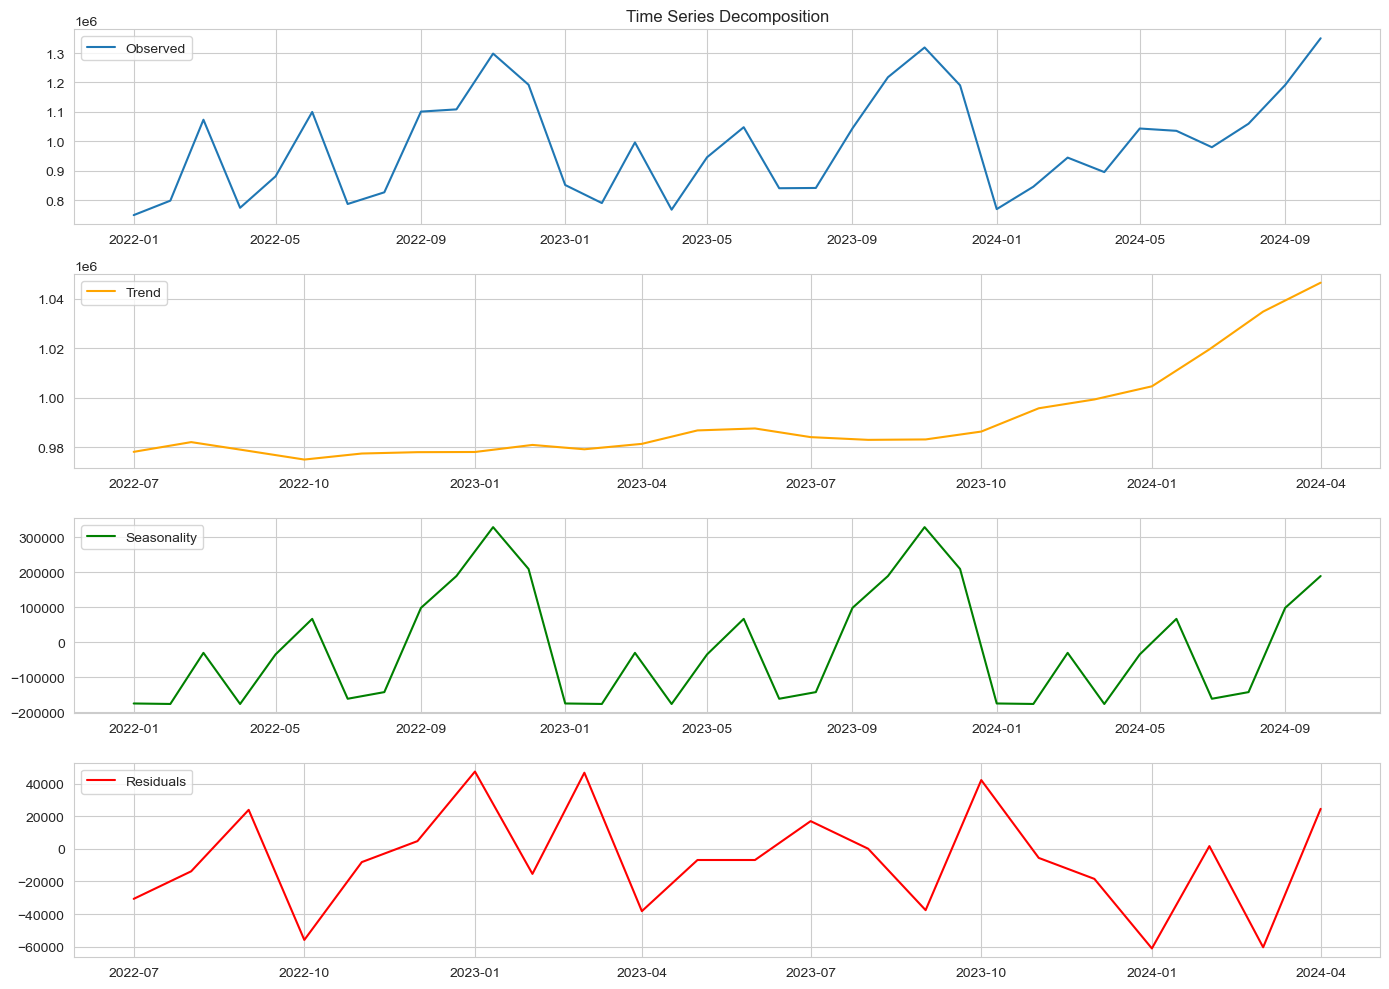

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We need a continuous time series for this. Let's take the total monthly sales.
# Ensure the index is a DatetimeIndex
monthly_sales_ts = train.groupby('date')['quantity'].sum()
monthly_sales_ts.index = pd.to_datetime(monthly_sales_ts.index)

# Decompose the time series (Period=12 for monthly data)
decomposition = seasonal_decompose(monthly_sales_ts, model='additive', period=12)

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

This is crucial for time series forecasting. It splits your data into three parts:

Trend: The long-term direction.

Seasonality: The repeating pattern.

Residual (Noise): The random variation.

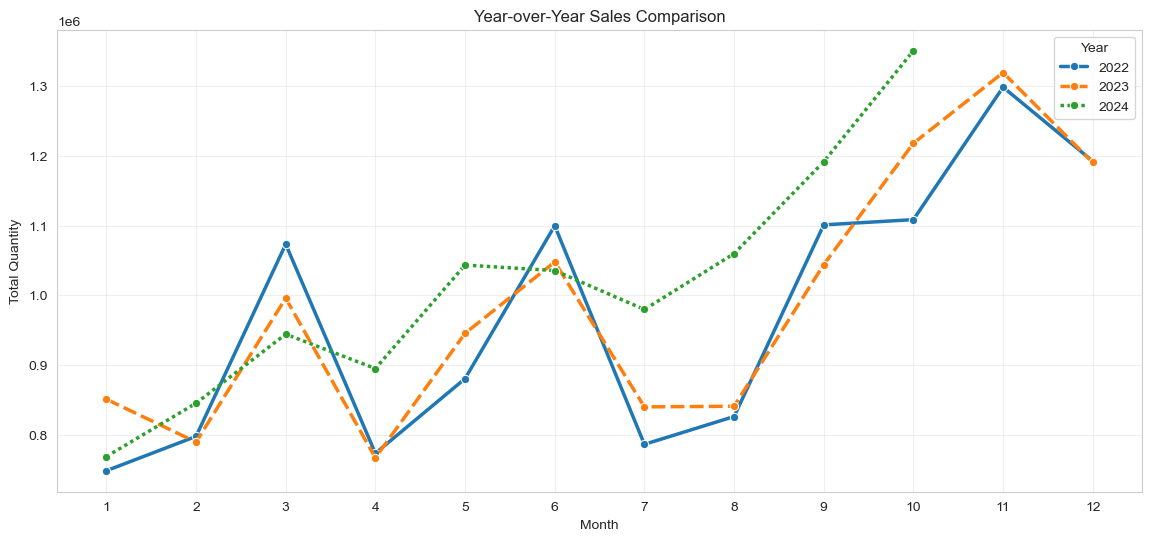

In [27]:
plt.figure(figsize=(14, 6))

# Pivot table to separate years into columns
yoy_sales = train.copy()
yoy_sales['month'] = yoy_sales['date'].dt.month
yoy_sales['year'] = yoy_sales['date'].dt.year
yoy_pivot = yoy_sales.groupby(['month', 'year'])['quantity'].sum().unstack()

# Plot each year
sns.lineplot(data=yoy_pivot, marker='o', linewidth=2.5, palette='tab10')
plt.title('Year-over-Year Sales Comparison')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True, alpha=0.3)
plt.show()

This plot overlaps the years to compare monthly performance directly. It's great for seeing if this year is performing better than the last.

In [19]:
print(f"Prediction Start Date: {submission['date'].min()}")
print(f"Prediction End Date: {submission['date'].max()}")
print(f"Total Months to Predict: {submission['date'].nunique()}")

# Parsing the unique_code in submission file to see market and product split
temp_sub = submission.copy()
temp_sub[['market', 'product_code']] = temp_sub['unique_code'].str.split('-', expand=True, n=1)

print("\nSample Parsed Submission Data:")
display(temp_sub.head())

Prediction Start Date: 2024-11-01 00:00:00
Prediction End Date: 2025-10-01 00:00:00
Total Months to Predict: 12

Sample Parsed Submission Data:


,ID,unique_code,date,quantity,market,product_code
0,0,MKT_001-PRD_0010,2024-11-01,0,MKT_001,PRD_0010
1,1,MKT_001-PRD_0010,2024-12-01,0,MKT_001,PRD_0010
2,2,MKT_001-PRD_0010,2025-01-01,0,MKT_001,PRD_0010
3,3,MKT_001-PRD_0010,2025-02-01,0,MKT_001,PRD_0010
4,4,MKT_001-PRD_0010,2025-03-01,0,MKT_001,PRD_0010


# ***🛠 Feature Engineering for Forecasting***

The create_features() function is responsible for preparing and engineering all relevant features from the raw datasets for demand forecasting. It includes the following steps:
1. Data Reading and Preparation
Load train.csv and product_master.csv.
Parse and standardize date columns.
Determine global min and max dates to align the time series.
2. Time Series Expansion (Grid Creation)
Fill gaps in the time series by creating a full monthly grid for each SKU and market combination.
Ensure that dates before the SKU’s first sale are excluded.
Merge original sales data and fill missing quantity values with zeros.
3. Historical Features
Extract month, quarter, and year.
Identify seasonal indicators such as:
is_q4, is_q1, is_summer, is_christmas_season, is_september.
4. Lifecycle Features
Calculate the time since first sale and since production start.
Estimate months until production end and total production lifetime.
Identify end-of-life SKUs and active production status.
Categorize SKUs into decay stages:
active, recent_end, mid_decay, late_decay, dead.
Encode decay stages numerically (decay_stage_enc) for modeling.
5. Lag and Rolling Features
Compute lagged quantities (1, 2, 3, 6, 12 months).
Compute rolling averages (3, 6, 12 months) to capture recent trends.
Calculate zero_ratio_12m: the ratio of months with zero sales over the past 12 months.
Compute sales trend (slope) over a 6-month rolling window to capture directional changes in demand.
6. Output Organization
Combine all relevant features into a final DataFrame with columns for:
Time features, seasonal indicators, lag/rolling features, lifecycle features, SKU/market identifiers, and target quantity.
This DataFrame is ready for model training and forecasting.

In [23]:
def create_features():
    # -------------------------------------------------------------------------
    # 1. DATA READING AND PREPARATION
    # -------------------------------------------------------------------------
    print("Reading files...")
    train = pd.read_csv('train.csv')
    product_master = pd.read_csv('product_master.csv')

    # Fix date formats
    train['date'] = pd.to_datetime(train['date'])
    product_master['start_production_date'] = pd.to_datetime(product_master['start_production_date'])
    product_master['end_production_date'] = pd.to_datetime(product_master['end_production_date'])

    # Global max date (The latest date in the dataset)
    global_max_date = train['date'].max()

    # -------------------------------------------------------------------------
    # 2. TIME SERIES EXPANSION (Grid Creation)
    # -------------------------------------------------------------------------
    print("Filling time series gaps...")

    starts = train.groupby(['market', 'product_code'])['date'].min().reset_index()
    starts.rename(columns={'date': 'start_date'}, inplace=True)

    global_min_date = train['date'].min()
    all_dates = pd.date_range(start=global_min_date, end=global_max_date, freq='MS')

    unique_combos = starts[['market', 'product_code']].drop_duplicates()
    unique_combos['key'] = 1
    dates_df = pd.DataFrame({'date': all_dates, 'key': 1})
    
    grid = unique_combos.merge(dates_df, on='key').drop('key', axis=1)
    
    grid = grid.merge(starts, on=['market', 'product_code'], how='left')
    grid = grid[grid['date'] >= grid['start_date']].drop('start_date', axis=1)

    df = grid.merge(train, on=['market', 'product_code', 'date'], how='left')
    df['quantity'] = df['quantity'].fillna(0)

    df = df.merge(product_master[['product_code', 'start_production_date', 'end_production_date']], 
                  on='product_code', how='left')

    df = df.sort_values(['market', 'product_code', 'date']).reset_index(drop=True)

    # -------------------------------------------------------------------------
    # 3. HISTORICAL FEATURES
    # -------------------------------------------------------------------------
    print("Creating historical features...")
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    
    df['is_q4'] = (df['quarter'] == 4).astype(int)
    df['is_q1'] = (df['quarter'] == 1).astype(int)
    df['is_september'] = (df['month'] == 9).astype(int)
    
    df['is_christmas_season'] = df['month'].isin([1, 11, 12]).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)

    # -------------------------------------------------------------------------
    # 4. LIFECYCLE FEATURES
    # -------------------------------------------------------------------------
    print("Creating lifecycle features...")

    first_sale = df.groupby(['market', 'product_code'])['date'].transform('min')
    df['months_since_first_sale'] = (df['date'] - first_sale).dt.days / 30.4375

    df['months_since_production_start'] = ((df['date'] - df['start_production_date']).dt.days / 30).fillna(0).astype(int)
    
    days_until_end = (df['end_production_date'] - df['date']).dt.days
    df['months_until_production_end'] = (days_until_end / 30).fillna(999).astype(int)
    df.loc[df['months_until_production_end'] < 0, 'months_until_production_end'] = 0
    
    df['production_lifetime_months'] = ((df['date'] - df['start_production_date']).dt.days / 30).fillna(0).astype(int)
    
    df['is_end_of_life'] = (df['date'] > df['end_production_date']).astype(int)
    df['is_production_active'] = (df['is_end_of_life'] == 0).astype(int)
    
    df['months_since_phase_out'] = ((df['date'] - df['end_production_date']).dt.days / 30).fillna(0).astype(int)
    df.loc[df['months_since_phase_out'] < 0, 'months_since_phase_out'] = 0

    def get_decay_stage(row):
        if row['is_end_of_life'] == 0:
            return 'active'
        elif row['months_since_phase_out'] <= 3:
            return 'recent_end'
        elif row['months_since_phase_out'] <= 12:
            return 'mid_decay'
        elif row['months_since_phase_out'] <= 24:
            return 'late_decay'
        else:
            return 'dead'

    df['decay_stage'] = df.apply(get_decay_stage, axis=1)
    
    decay_map = {'active': 0, 'recent_end': 4, 'mid_decay': 3, 'late_decay': 2, 'dead': 1}
    df['decay_stage_enc'] = df['decay_stage'].map(decay_map)

    # -------------------------------------------------------------------------
    # 5. LAG AND ROLLING FEATURES
    # -------------------------------------------------------------------------
    print("Calculating Lag and Rolling features...")
    
    g = df.groupby(['market', 'product_code'])['quantity']
    
    for lag in [1, 2, 3, 6, 12]:
        df[f'lag_{lag}'] = g.shift(lag).fillna(0)

    shifted = g.shift(1)
    df['rolling_mean_3'] = shifted.rolling(window=3, min_periods=1).mean().fillna(0)
    df['rolling_mean_6'] = shifted.rolling(window=6, min_periods=1).mean().fillna(0)
    df['rolling_mean_12'] = shifted.rolling(window=12, min_periods=1).mean().fillna(0)

    df['zero_ratio_12m'] = df.groupby(['market', 'product_code'])['quantity'].transform(
        lambda x: (x.shift(1) == 0).astype(float).rolling(window=12, min_periods=1).mean()
    ).fillna(0)

    def calc_slope(x):
        if len(x) < 2: return 0
        y = x.values
        if np.isnan(y).any(): return 0
        X = np.arange(len(y))
        slope = np.polyfit(X, y, 1)[0]
        return slope

    print("Calculating trend (This process may take a while)...")
    df['sales_trend_6m'] = df.groupby(['market', 'product_code'])['quantity'].transform(
        lambda x: x.shift(1).rolling(window=6, min_periods=2).apply(calc_slope, raw=False)
    ).fillna(0)

    # -------------------------------------------------------------------------
    # 6. OUTPUT ORGANIZATION
    # -------------------------------------------------------------------------
    final_cols = [
        'month', 'quarter', 'year', 'is_q4', 'is_christmas_season', 'is_q1', 
        'is_summer', 'is_september', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12',
        'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'sales_trend_6m',
        'zero_ratio_12m', 'months_since_first_sale', 'is_production_active',
        'months_since_production_start', 'months_until_production_end',
        'is_end_of_life', 'months_since_phase_out', 'production_lifetime_months',
        'decay_stage', 'market', 'product_code', 'date', 'quantity', 'decay_stage_enc'
    ]
    
    df_final = df[final_cols]
    
    print(f"Completed. Output shape: {df_final.shape}")
    return df_final


In [25]:
# Running the code
if __name__ == "__main__":
    final_features = create_features()
    pd.set_option('display.max_columns', None)
    print(final_features.head())
    final_features.to_csv("final_features.csv", index=False)


Reading files...
Filling time series gaps...
Creating historical features...
Creating lifecycle features...
Calculating Lag and Rolling features...
Calculating trend (This process may take a while)...
Completed. Output shape: (458481, 31)
   month  quarter  year  is_q4  is_christmas_season  is_q1  is_summer  \
0      1        1  2022      0                    1      1          0   
1      2        1  2022      0                    0      1          0   
2      3        1  2022      0                    0      1          0   
3      4        2  2022      0                    0      0          0   
4      5        2  2022      0                    0      0          0   

   is_september   lag_1   lag_2   lag_3  lag_6  lag_12  rolling_mean_3  \
0             0     0.0     0.0     0.0    0.0     0.0        0.000000   
1             0   649.0     0.0     0.0    0.0     0.0      649.000000   
2             0  1964.0   649.0     0.0    0.0     0.0     1306.500000   
3             0  1505.0  1

In [ ]:
# METRIC FUNCTIONS

BASELINE_GROUP_WMAPE = 0.8775865632406377

def rwmape(y_true: np.ndarray, y_pred: np.ndarray, gamma: float = 0.8, lam: float = 0.2, eps: float = 1e-9) -> float:
    """Regularized WMAPE (lower is better)."""
    y_true = y_true.astype(float)
    y_pred = y_pred.astype(float)
    num = np.sum(np.abs(y_true - y_pred)) + lam * np.abs(np.sum(y_true) - np.sum(y_pred))
    den = np.sum(np.abs(y_true)) + gamma * np.sum(np.abs(y_pred)) + eps
    return float(num / den)

def group_wmape(df: pd.DataFrame, group_cols, target_col: str, pred_col: str,
                gamma: float = 0.8, lam: float = 0.2, eps: float = 1e-9) -> float:
    scores = []
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0.0).astype(float)
    p = pd.to_numeric(df[pred_col], errors="coerce").fillna(0.0).astype(float)
    work = df.copy()
    work[target_col] = y.values
    work[pred_col] = p.values
    
    for _, g in work.groupby(list(group_cols), sort=False, dropna=False):
        y_g = g[target_col].to_numpy(dtype=float)
        p_g = g[pred_col].to_numpy(dtype=float)
        sum_true = float(np.sum(np.abs(y_g)))
        sum_pred = float(np.sum(np.abs(p_g)))
        if sum_true == 0.0 and sum_pred == 0.0:
            continue
        if sum_true == 0.0 and sum_pred > 0.0:
            scores.append(1.0)
        else:
            scores.append(rwmape(y_g, p_g, gamma=gamma, lam=lam, eps=eps))
    return float(np.mean(scores)) if scores else 0.0

def group_wmape_opt(df: pd.DataFrame, group_cols, target_col: str, pred_col: str,
                gamma: float = 0.8, lam: float = 0.2, eps: float = 1e-9) -> float:
    # Optimized version for loop usage
    return group_wmape(df, group_cols, target_col, pred_col, gamma, lam, eps)

def score(solution: pd.DataFrame,
          submission: pd.DataFrame,
          target_col: str = "quantity",
          group_cols = ("unique_code",),
          row_id_col: str | None = None,
          baseline_group_wmape: float = BASELINE_GROUP_WMAPE,
          gamma: float = 0.8, lam: float = 0.2, eps: float = 1e-9) -> float:
    if row_id_col:
        merged = pd.merge(
            solution,
            submission[[row_id_col, target_col]].rename(columns={target_col: f"{target_col}_pred"}),
            on=row_id_col, how="inner", validate="one_to_one"
        )
    else:
        if len(solution) != len(submission):
            raise ValueError("Without row_id_col, solution and submission must have same length.")
        merged = solution.copy()
        merged[f"{target_col}_pred"] = submission[target_col].values
    
    gw = group_wmape(merged, group_cols=group_cols, target_col=target_col,
                     pred_col=f"{target_col}_pred", gamma=gamma, lam=lam, eps=eps)
    return float(baseline_group_wmape / (gw + eps))

In [ ]:
# STEP 1: Load Data & Parse Hierarchy

df_train = pd.read_csv('final_features.csv', parse_dates=['date'])
df_sub_template = pd.read_csv('submission.csv')
master = pd.read_csv('product_master.csv')

# Merge hierarchy information
df_train = df_train.merge(master, on='product_code', how='left')

# Fill missing hierarchy values
hierarchy_cols = ['category', 'business_line_code', 'business_line', 'sector', 
                   'structure_code', 'factory', 'brand']
for col in hierarchy_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna('UNKNOWN')

# ***🔧 Advanced Feature Engineering***
## This section focuses on higher-level feature engineering for forecasting, building upon the basic features created earlier.
1. Aggregations
Aggregate lagged sales (lag_1) at multiple hierarchy levels:
Category: sum, mean, median, std, max
Business Line: sum, mean, volatility
Sector: sum, mean
Business Line Code (BLC): sum
Factory & Brand: sum, mean
These aggregated features capture collective trends at different levels of the product hierarchy.
2. Share Features
Calculate relative contributions of SKUs or groups:
SKU share in category
Category share in business line
Business line share in sector
Sector share in BLC
SKU, factory, and brand share in market
Helps the model understand SKU importance within its hierarchy.
3. Rolling & Momentum Features
Rolling averages (3-month for category) to smooth short-term fluctuations.
Momentum (6-month) for category, sector, and business line:
Captures rate of change in past sales.
Volatility (std) for business lines over 6 months:
Measures stability or variability in sales.
These features highlight trends and short-term dynamics.
4. Interactions & Advanced Features
Combine multiple features to capture complex interactions:
hierarchy_momentum_cascade: product of sector, business line, category momentum, and SKU sales trend
market_category_strength: SKU share × category share × category momentum
factory_brand_synergy: interaction between factory and brand sales relative to market
category_lifecycle_interaction: category mean × months since production start
sector_maturity_effect: sector total × production active indicator
Seasonal and promotion effects: category_q4_effect, sector_christmas_boost, bl_summer_pattern
Dominance & z-score metrics to capture relative performance within hierarchies
5. Data Cleaning
Fill missing values (NaN) for all numeric features with 0.
Ensures the dataset is model-ready and free from missing data issues.

In [ ]:
# STEP 2-4: Feature Engineering

# Sort by date
df_train = df_train.sort_values(['market', 'product_code', 'date']).reset_index(drop=True)

# 1. Aggregations
# Category
category_aggs = df_train.groupby(['date', 'market', 'category'])['lag_1'].agg([
    ('category_total_lag1', 'sum'), ('category_mean_lag1', 'mean'),
    ('category_median_lag1', 'median'), ('category_std_lag1', 'std'), ('category_max_lag1', 'max')
]).reset_index()
df_train = df_train.merge(category_aggs, on=['date', 'market', 'category'], how='left')

# Business Line
bl_aggs = df_train.groupby(['date', 'market', 'business_line'])['lag_1'].agg([
    ('bl_total_lag1', 'sum'), ('bl_mean_lag1', 'mean'), ('bl_volatility_lag1', 'std')
]).reset_index()
df_train = df_train.merge(bl_aggs, on=['date', 'market', 'business_line'], how='left')

# Sector
sector_aggs = df_train.groupby(['date', 'market', 'sector'])['lag_1'].agg([
    ('sector_total_lag1', 'sum'), ('sector_mean_lag1', 'mean')
]).reset_index()
df_train = df_train.merge(sector_aggs, on=['date', 'market', 'sector'], how='left')

# BLC
blc_aggs = df_train.groupby(['date', 'market', 'business_line_code'])['lag_1'].agg([
    ('blc_total_lag1', 'sum')
]).reset_index()
df_train = df_train.merge(blc_aggs, on=['date', 'market', 'business_line_code'], how='left')

# Factory & Brand
factory_aggs = df_train.groupby(['date', 'factory'])['lag_1'].agg([('factory_total_lag1', 'sum'), ('factory_mean_lag1', 'mean')]).reset_index()
brand_aggs = df_train.groupby(['date', 'brand'])['lag_1'].agg([('brand_total_lag1', 'sum'), ('brand_mean_lag1', 'mean')]).reset_index()
df_train = df_train.merge(factory_aggs, on=['date', 'factory'], how='left')
df_train = df_train.merge(brand_aggs, on=['date', 'brand'], how='left')

# 2. Shares
market_aggs = df_train.groupby(['date', 'market'])['lag_1'].agg([('market_total_lag1', 'sum')]).reset_index()
df_train = df_train.merge(market_aggs, on=['date', 'market'], how='left')

df_train['sku_share_in_category'] = df_train['lag_1'] / (df_train['category_total_lag1'] + 1)
df_train['category_share_in_bl'] = df_train['category_total_lag1'] / (df_train['bl_total_lag1'] + 1)
df_train['bl_share_in_sector'] = df_train['bl_total_lag1'] / (df_train['sector_total_lag1'] + 1)
df_train['sector_share_in_blc'] = df_train['sector_total_lag1'] / (df_train['blc_total_lag1'] + 1)
df_train['sku_share_in_market'] = df_train['lag_1'] / (df_train['market_total_lag1'] + 1)
df_train['factory_market_share'] = df_train['factory_total_lag1'] / (df_train['market_total_lag1'] + 1)
df_train['brand_market_share'] = df_train['brand_total_lag1'] / (df_train['market_total_lag1'] + 1)

# 3. Rolling & Momentum
def calculate_momentum(x):
    if len(x) < 2: return 0.0
    return (x.iloc[-1] - x.iloc[0]) / (x.iloc[0] + 1e-9)

df_train['category_rolling_3m'] = df_train.groupby(['market', 'category'])['category_total_lag1'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df_train['sector_momentum_6m'] = df_train.groupby(['market', 'sector'])['sector_total_lag1'].transform(lambda x: x.rolling(6, min_periods=1).apply(calculate_momentum, raw=False))
df_train['bl_volatility_6m'] = df_train.groupby(['market', 'business_line'])['bl_total_lag1'].transform(lambda x: x.rolling(6, min_periods=1).std())
df_train['category_momentum_6m'] = df_train.groupby(['market', 'category'])['category_total_lag1'].transform(lambda x: x.rolling(6, min_periods=1).apply(calculate_momentum, raw=False))
df_train['bl_momentum_6m'] = df_train.groupby(['market', 'business_line'])['bl_total_lag1'].transform(lambda x: x.rolling(6, min_periods=1).apply(calculate_momentum, raw=False))

# 4. Interactions & Advanced
df_train['hierarchy_momentum_cascade'] = (df_train['sector_momentum_6m'] * df_train['bl_momentum_6m'] * df_train['category_momentum_6m'] * df_train['sales_trend_6m'].fillna(0))
df_train['market_category_strength'] = (df_train['sku_share_in_market'] * df_train['category_share_in_bl'] * df_train['category_momentum_6m'])
df_train['factory_brand_synergy'] = (df_train['factory_total_lag1'] * df_train['brand_total_lag1'] / (df_train['market_total_lag1'] + 1))
df_train['category_lifecycle_interaction'] = (df_train['category_mean_lag1'] * df_train['months_since_production_start'].fillna(0))
df_train['sector_maturity_effect'] = (df_train['sector_total_lag1'] * df_train['is_production_active'])
df_train['brand_eol_effect'] = (df_train['brand_mean_lag1'] * df_train['is_end_of_life'])
df_train['category_q4_effect'] = df_train['category_mean_lag1'] * df_train['is_q4']
df_train['sector_christmas_boost'] = df_train['sector_total_lag1'] * df_train['is_christmas_season']
df_train['bl_summer_pattern'] = df_train['bl_mean_lag1'] * df_train['is_summer']

df_train['sku_dominance_in_category'] = df_train['lag_1'] / (df_train['category_max_lag1'] + 1)
bl_max = df_train.groupby(['date', 'market', 'business_line'])['category_total_lag1'].max().reset_index(name='bl_max_lag1')
df_train = df_train.merge(bl_max, on=['date', 'market', 'business_line'], how='left')
df_train['category_dominance_in_bl'] = df_train['category_total_lag1'] / (df_train['bl_max_lag1'] + 1)
df_train['sku_zscore_in_category'] = ((df_train['lag_1'] - df_train['category_mean_lag1']) / (df_train['category_std_lag1'] + 1))

# Fill NA
cols_to_fill = [c for c in df_train.columns if df_train[c].dtype in ['float64', 'float32']]
df_train[cols_to_fill] = df_train[cols_to_fill].fillna(0)

print('Features restored')

# ***🎯 Feature Selection and Dataset Preparation***
## In this step, we select the relevant features for modeling and prepare the training dataset.
1. Base Features
Core time, seasonal, lag, rolling, trend, lifecycle, and decay features:
Example: month, quarter, lag_1, rolling_mean_3, sales_trend_6m, months_since_first_sale, decay_stage_enc, etc.
Capture temporal patterns, seasonality, and SKU lifecycle dynamics.
2. Hierarchical Features
Categorical hierarchy: market, product_code, structure_code, category, business_line, sector, business_line_code, factory, brand
Numerical hierarchy features: aggregated sales, rolling averages, momentum, volatility, shares, interactions, dominance, z-scores, and seasonal/interaction effects
Designed to capture relationships across the product hierarchy and market-level dynamics.
3. Construct Final Training Matrices
Numerical features: fill missing values with 0
Categorical features: cast as category type
Combine into X_train
Target variable: y_train = quantity
4. Binary Target & Positive Data Subset
Create binary target for modeling presence/absence of demand:
y_train_binary = (y_train > 0).astype(int)
Select only positive demand rows for regression tasks:
X_train_pos, y_train_pos
Ensures models can separately handle classification (zero vs non-zero demand) and regression (positive demand magnitude).

In [ ]:
# STEP 5: Feature Selection

base_features = [
    'month', 'quarter', 'year', 'is_q4', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12',
    'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'sales_trend_6m', 'zero_ratio_12m',
    'months_since_first_sale', 'is_christmas_season', 'is_q1', 'is_summer', 'is_september',
    'is_production_active', 'months_since_production_start', 'months_until_production_end',
    'is_end_of_life', 'months_since_phase_out', 'production_lifetime_months', 'decay_stage_enc'
]

hierarchical_cat_features = ['market', 'product_code', 'structure_code', 'category', 'business_line', 'sector', 'business_line_code', 'factory', 'brand']
hierarchical_num_features = [
    'category_total_lag1', 'category_mean_lag1', 'category_median_lag1', 'category_std_lag1', 'category_max_lag1',
    'bl_total_lag1', 'bl_mean_lag1', 'bl_volatility_lag1', 'sector_total_lag1', 'sector_mean_lag1', 'blc_total_lag1',
    'factory_total_lag1', 'factory_mean_lag1', 'brand_total_lag1', 'brand_mean_lag1', 'market_total_lag1',
    'sku_share_in_category', 'category_share_in_bl', 'bl_share_in_sector', 'sector_share_in_blc',
    'sku_share_in_market', 'factory_market_share', 'brand_market_share',
    'category_rolling_3m', 'sector_momentum_6m', 'bl_volatility_6m', 'category_momentum_6m', 'bl_momentum_6m',
    'hierarchy_momentum_cascade', 'market_category_strength', 'factory_brand_synergy',
    'category_lifecycle_interaction', 'sector_maturity_effect', 'brand_eol_effect',
    'category_q4_effect', 'sector_christmas_boost', 'bl_summer_pattern',
    'sku_dominance_in_category', 'category_dominance_in_bl', 'sku_zscore_in_category'
]

all_num_features = base_features + [f for f in hierarchical_num_features if f in df_train.columns]
all_cat_features = [f for f in hierarchical_cat_features if f in df_train.columns]

X_train_num = df_train[all_num_features].fillna(0)
X_train_cat = df_train[all_cat_features].astype('category')
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
y_train = df_train['quantity']

# Binary Target & Positive Data
y_train_binary = (y_train > 0).astype(int)
mask_positive = y_train > 0
X_train_pos = X_train[mask_positive]
y_train_pos = y_train[mask_positive]

# ***⚡ Model Training (Classifier & Regressor Ensembles)***
## This step covers the LightGBM modeling pipeline using multiple seeds and architectures for robust SKU-level demand forecasting.
1. Seed Strategy
Multiple seeds
Purpose:
Increase diversity in the ensemble
Improve robustness and reduce overfitting
Support multiple architectures
2. Model Architectures
Architecture 1: DEEP (Aggressive / Complex Patterns)
Captures complex relationships and subtle interactions.
3. Two-Stage Training
Stage 1 – Classifier
Objective: Predict whether demand > 0 for each SKU.
Model: Binary LightGBM Classifier
Shared DEEP architecture across multiple seeds.
Stage 2 – Regressor
Objective: Predict quantity for positive-demand SKUs.
Two architectures:
DEEP: aggressive, captures complex patterns
SHALLOW: conservative, robust to outliers
4. Ensemble Strategy
Multiple models per seed and per architecture.
Predictions are later averaged or combined to enhance stability and accuracy.
This approach balances:
Flexibility (deep models)
Stability (shallow models)
Robustness (seed diversity)

In [ ]:
SEEDS = [42, 2024, 555, 1999, 101, 1234] # Reduced slightly for speed, increased diversity via architecture

# ARCHITECTURE 1: DEEP (Complex patterns)
params_deep = {
    'verbosity': -1, 'categorical_feature': all_cat_features,
    'num_leaves': 200, 'learning_rate': 0.035, 'feature_fraction': 0.85,
    'bagging_fraction': 0.85, 'bagging_freq': 3, 'min_child_samples': 25,
    'max_depth': 15, 'lambda_l1': 3.0, 'lambda_l2': 3.0, 'n_estimators': 1000,
    'force_row_wise': True, 'cat_smooth': 20, 'max_cat_threshold': 64
}

# ARCHITECTURE 2: SHALLOW (Robust/Conservative)
params_shallow = {
    'verbosity': -1, 'categorical_feature': all_cat_features,
    'num_leaves': 63, 'learning_rate': 0.045, 'feature_fraction': 0.70,
    'bagging_fraction': 0.80, 'bagging_freq': 5, 'min_child_samples': 50, # More samples per leaf = smoother
    'max_depth': 8, # Shallower
    'lambda_l1': 5.0, 'lambda_l2': 5.0, # Stronger regularization
    'n_estimators': 1200,
    'force_row_wise': True, 'cat_smooth': 30
}

models_clf = []
models_reg_deep = []
models_reg_shallow = []

print('Training Stage 1: Classifier (Shared)...')
for seed in SEEDS:
    p_clf = params_deep.copy()
    p_clf.update({'objective': 'binary', 'metric': 'auc', 'random_state': seed})
    clf = lgb.LGBMClassifier(**p_clf)
    clf.fit(X_train, y_train_binary)
    models_clf.append(clf)

print('Training Stage 2: Regressor DEEP (Aggressive)...')
for seed in SEEDS:
    p_reg = params_deep.copy()
    p_reg.update({'objective': 'mae', 'metric': 'mae', 'random_state': seed})
    reg = lgb.LGBMRegressor(**p_reg)
    reg.fit(X_train_pos, y_train_pos)
    models_reg_deep.append(reg)

print('Training Stage 2: Regressor SHALLOW (Conservative)...')
for seed in SEEDS:
    p_reg = params_shallow.copy()
    p_reg.update({'objective': 'mae', 'metric': 'mae', 'random_state': seed})
    reg = lgb.LGBMRegressor(**p_reg)
    reg.fit(X_train_pos, y_train_pos)
    models_reg_shallow.append(reg)

print('Training Complete!')

# ***🧪 Threshold Optimization & Validation***
## This step focuses on optimizing the decision threshold for converting classifier probabilities into final SKU demand predictions, using the last 15% of the dataset as a validation set.
1. Validation Set Preparation
Cutoff: last 15% of the dataset by date.
Construct numerical (X_val_num) and categorical (X_val_cat) features.
Combine into a single validation matrix (X_val).
Create val_solution DataFrame with a unique SKU-market code for aggregation.
2. Predictions on Validation
Classifier ensemble: average predicted probabilities of non-zero demand (probs_val) across multiple seeds.
Regressor ensembles: average predicted quantities separately for DEEP and SHALLOW regressors.
Blend regressors with 50%-50% weighting to produce avg_quantity_val.
3. Threshold Optimization
Iterate thresholds from 0.10 to 0.60 (step=0.02).
Apply threshold to classifier probabilities:
val_pred = 0 if probs_val < threshold
Otherwise: val_pred = probs_val * avg_quantity_val
Seasonal adjustment: lower threshold by 15% during Christmas season to capture higher demand.
Round predictions to integer quantities.
Evaluate using grouped WMAPE (group_wmape_opt).
4. Results
Best base threshold: best_threshold
Validation metrics:
Grouped WMAPE: BEST_GROUP_WMAPE
Approximate local score: BEST_LOCAL_SCORE
Ensures that the final predictions are calibrated for both zero-demand and positive-demand SKUs, with seasonal adjustments.

In [ ]:
# STEP 7: Threshold Optimization (Validation)
# Use last 15% as validation
val_cutoff_date = df_train['date'].quantile(0.85)
val_mask = df_train['date'] >= val_cutoff_date

X_val_num = df_train.loc[val_mask, all_num_features].fillna(0)
X_val_cat = df_train.loc[val_mask, all_cat_features].astype('category')
X_val = pd.concat([X_val_num, X_val_cat], axis=1)
y_val = df_train.loc[val_mask, 'quantity'].values
val_solution = df_train.loc[val_mask].copy()
val_solution['unique_code'] = val_solution['market'].astype(str) + '-' + val_solution['product_code'].astype(str)

# Predictions on Validation
probs_val = np.zeros(len(X_val))
quantities_val_deep = np.zeros(len(X_val))
quantities_val_shallow = np.zeros(len(X_val))

for clf in models_clf:
    probs_val += clf.predict_proba(X_val)[:, 1]
probs_val /= len(models_clf)

for reg in models_reg_deep:
    quantities_val_deep += reg.predict(X_val)
quantities_val_deep /= len(models_reg_deep)

for reg in models_reg_shallow:
    quantities_val_shallow += reg.predict(X_val)
quantities_val_shallow /= len(models_reg_shallow)

# Blend Regressors
avg_quantity_val = (quantities_val_deep * 0.5) + (quantities_val_shallow * 0.5)

# Optimize
best_threshold = 0.20
best_score = float('inf')

for thresh in np.arange(0.10, 0.60, 0.02):
    val_pred = probs_val * avg_quantity_val
    val_pred = np.where(probs_val < thresh, 0, val_pred)
    # Seasonal Threshold Relaxation Logic (Same as will be applied in test)
    # If christmas season, effectively lower threshold by 15%
    is_christmas = X_val['is_christmas_season'].values == 1
    relaxed_thresh = thresh * 0.85
    val_pred = np.where((is_christmas) & (probs_val > relaxed_thresh), probs_val * avg_quantity_val, val_pred)
    
    val_pred = np.round(val_pred)
    val_df = val_solution[['unique_code', 'quantity']].copy().reset_index(drop=True)
    val_df['quantity_pred'] = val_pred
    
    s = group_wmape_opt(val_df, ('unique_code',), 'quantity', 'quantity_pred')
    if s < best_score:
        best_score = s
        best_threshold = thresh

print(f'Best Base Threshold: {best_threshold:.3f}')

# Derive local score equivalent using the same transformation as `score`
BEST_GROUP_WMAPE = best_score
BEST_LOCAL_SCORE = BASELINE_GROUP_WMAPE / (BEST_GROUP_WMAPE + 1e-9)
print(f'   → Best validation group WMAPE: {BEST_GROUP_WMAPE:.6f}')
print(f'   → Approx. local validation score: {BEST_LOCAL_SCORE:.6f}')

# ***📤 Prepare Submission Features***
## This step focuses on constructing the feature matrix for test/submission data and ensuring it is compatible with the trained models.
1. Base Setup
Start with df_sub_template.
Extract market and product_code from unique_code.
Merge with master table to include product metadata.
Convert production dates to datetime.
Fill missing hierarchical/categorical values with "UNKNOWN".
2. Temporal & Seasonal Features
Extract month, quarter, year.
Flag key seasonal patterns:
Q1, Q4, summer months, September
Christmas season: November & December
Determine production status:
is_production_active
is_end_of_life
Months since production start / until production end
Months since phase-out
Total production lifetime
3. Decay & Lifecycle Encoding
Encode decay stage: decay_stage_enc
Active = 0
End-of-life = 1
Ensures the model can handle SKU lifecycle dynamics during submission.
4. Lags & Rolling Features
Transfer last known lag and rolling values from the training set:
Both base lags (lag_1, lag_2, rolling_mean_3, etc.) and hierarchical/advanced numerical features
Missing values are filled with 0 to maintain model compatibility.
5. Interaction Features
Recalculate seasonal & category/sector interactions:
category_q4_effect = category_mean_lag1 * is_q4
sector_christmas_boost = sector_total_lag1 * is_christmas_season
6. Final Submission Matrix
Ensure all required numerical and categorical features exist.
Numerical features: X_sub_num
Categorical features: X_sub_cat
Combine into final submission-ready matrix: X_sub

In [ ]:
# STEP 8: Prepare Submission Features
df_sub = df_sub_template.copy()
df_sub[['market', 'product_code']] = df_sub['unique_code'].str.split('-', expand=True)
df_sub['date'] = pd.to_datetime(df_sub['date'])
df_sub = df_sub.merge(master, on='product_code', how='left')

# Convert production dates to datetime
df_sub['start_production_date'] = pd.to_datetime(df_sub['start_production_date'], errors='coerce')
df_sub['end_production_date'] = pd.to_datetime(df_sub['end_production_date'], errors='coerce')

for col in hierarchy_cols:
    if col in df_sub.columns: df_sub[col] = df_sub[col].fillna('UNKNOWN')

# Feature Gen
df_sub['month'] = df_sub['date'].dt.month
df_sub['quarter'] = df_sub['date'].dt.quarter
df_sub['year'] = df_sub['date'].dt.year
df_sub['is_q4'] = (df_sub['quarter'] == 4).astype(int)
df_sub['is_christmas_season'] = (df_sub['month'].isin([11, 12])).astype(int)
df_sub['is_q1'] = (df_sub['quarter'] == 1).astype(int)
df_sub['is_summer'] = (df_sub['month'].isin([6, 7, 8])).astype(int)
df_sub['is_september'] = (df_sub['month'] == 9).astype(int)
df_sub['is_production_active'] = ((df_sub['date'] >= df_sub['start_production_date']) & ((df_sub['end_production_date'].isna()) | (df_sub['date'] <= df_sub['end_production_date']))).astype(int)
df_sub['months_since_production_start'] = ((df_sub['date'] - df_sub['start_production_date']).dt.days / 30.44).fillna(-1).clip(-1, 200)
df_sub['months_until_production_end'] = np.where(df_sub['end_production_date'].isna(), 999, ((df_sub['end_production_date'] - df_sub['date']).dt.days / 30.44).clip(lower=0, upper=999))
df_sub['is_end_of_life'] = ((~df_sub['end_production_date'].isna()) & (df_sub['date'] > df_sub['end_production_date'])).astype(int)
df_sub['months_since_phase_out'] = np.where(df_sub['end_production_date'].isna(), 0, np.maximum(0, (df_sub['date'] - df_sub['end_production_date']).dt.days / 30.44)).clip(0, 100)
df_sub['production_lifetime_months'] = ((df_sub['end_production_date'] - df_sub['start_production_date']).dt.days / 30.44).fillna(0).clip(0, 300)
df_sub['decay_stage_enc'] = 0
df_sub.loc[df_sub['is_end_of_life'] == 1, 'decay_stage_enc'] = 1

# Lags from train last values
last_train = df_train.sort_values('date').groupby(['market', 'product_code']).tail(1).set_index(['market', 'product_code'])
lag_cols = [c for c in all_num_features if c not in df_sub.columns] # Approximate logic for brevity

# Transfer last known values for lags & rolling
cols_to_transfer = [c for c in all_num_features if c not in base_features and c not in df_sub.columns]
for col in cols_to_transfer:
    # Use map for speed
    mapping = last_train[col].to_dict()
    df_sub[col] = df_sub.set_index(['market', 'product_code']).index.map(mapping).fillna(0)

# Also transfer base lag features
base_lags = ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'sales_trend_6m', 'zero_ratio_12m', 'months_since_first_sale']
for col in base_lags:
    if col in last_train.columns:
        mapping = last_train[col].to_dict()
        df_sub[col] = df_sub.set_index(['market', 'product_code']).index.map(mapping).fillna(0)
    else:
        df_sub[col] = 0

# Recalculate season interactions
df_sub['category_q4_effect'] = df_sub['category_mean_lag1'] * df_sub['is_q4']
df_sub['sector_christmas_boost'] = df_sub['sector_total_lag1'] * df_sub['is_christmas_season']

# Ensure all required features exist, fill missing ones with 0
missing_features = [f for f in all_num_features if f not in df_sub.columns]
for col in missing_features:
    df_sub[col] = 0

X_sub_num = df_sub[all_num_features].fillna(0)
X_sub_cat = df_sub[all_cat_features].astype('category')
X_sub = pd.concat([X_sub_num, X_sub_cat], axis=1)

# ***🚀 Prediction with Ensemble & Bias Correction***
## This step focuses on generating the final SKU demand predictions using the trained ensemble models and applying bias correction and seasonal threshold logic.
1. Classifier & Regressor Predictions
Classifier ensemble: average predicted probabilities of non-zero demand across multiple seeds.
Regressor ensembles:
DEEP (aggressive) and SHALLOW (conservative) regressors.
Blend predictions using 50%-50% weighting:
2. Bias Correction
MAE-targeted models tend to underestimate high sales (mean > median).
Apply a small multiplier (1.015) to positive predictions to better capture demand peaks:
3. Hybrid Prediction
Multiply classifier probability with bias-corrected quantity:
4. Dynamic Seasonal Thresholding
Apply base threshold to zero-out low probability SKUs:
Relaxed threshold during Christmas season to capture potential sales spikes:
Relaxed threshold = best_threshold * 0.85
Recover predictions in the “maybe” zone for Christmas SKUs.
Ensures seasonal spikes are not missed.
5. Clipping & Rounding
Clip predictions at 99.5th percentile of non-zero predictions to prevent extreme outliers.
Round predictions to integers for final SKU quantity.

In [ ]:
# STEP 9: Prediction with Ensemble & Bias Correction
probs_accum = np.zeros(len(X_sub))
quantities_accum_deep = np.zeros(len(X_sub))
quantities_accum_shallow = np.zeros(len(X_sub))

print('Classifier Voting...')
for clf in models_clf:
    probs_accum += clf.predict_proba(X_sub)[:, 1]
avg_prob = probs_accum / len(models_clf)

print('Regressor Blending (Deep)...')
for reg in models_reg_deep:
    quantities_accum_deep += reg.predict(X_sub)

print('Regressor Blending (Shallow)...')
for reg in models_reg_shallow:
    quantities_accum_shallow += reg.predict(X_sub)

# HYBRID AVERAGE
avg_quantity = (quantities_accum_deep / len(models_reg_deep)) * 0.5 + (quantities_accum_shallow / len(models_reg_shallow)) * 0.5

# BIAS CORRECTION (MAE Correction)
# MAE targets median. Sales data mean is > median. 
# Small multiplier for positive predictions to capture peaks better.
avg_quantity = avg_quantity * 1.015 

# Final Calculation
final_pred = avg_prob * avg_quantity

# DYNAMIC SEASONAL THRESHOLDING
print('Applying Seasonal Threshold Logic...')
# Standard threshold
final_pred = np.where(avg_prob < best_threshold, 0, final_pred)

# Relaxed threshold for Christmas Season (Catch more sales)
relaxed_threshold = best_threshold * 0.85
is_christmas_sub = df_sub['is_christmas_season'] == 1
# Only if we zeroed it out but it was in the "maybe" zone (relaxed < p < standard) AND it is christmas
recover_mask = (avg_prob >= relaxed_threshold) & (avg_prob < best_threshold) & (is_christmas_sub)
final_pred[recover_mask] = (avg_prob[recover_mask] * avg_quantity[recover_mask])
print(f'Rescued {recover_mask.sum():,} predictions due to seasonal logic')

# Clipping & Rounding
p99_5 = np.percentile(final_pred[final_pred > 0], 99.5) if (final_pred > 0).sum() > 0 else final_pred.max()
final_pred = np.clip(final_pred, 0, p99_5)
final_pred = np.round(final_pred)

# Save
submission = pd.DataFrame({
    'ID': df_sub['ID'],
    'date': df_sub['date'].dt.strftime('%Y-%m-%d'),
    'quantity': final_pred
})
submission.to_csv('sonkurşun_2.csv', index=False)

print('SUBMISSION READY')
print(f'Mean: {final_pred.mean():.4f}')
print(f'Zeros: {(final_pred==0).mean()*100:.2f}%')

try:
    print(f'Local validation group WMAPE: {BEST_GROUP_WMAPE:.6f}')
    print(f'Approx. local validation score: {BEST_LOCAL_SCORE:.6f}')
except NameError:

    pass